On commence par import les librairies nécessaires 

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#charger les données
from sklearn.datasets import load_breast_cancer 
#fonction pour diviser les jeux de données en entrai/test
from sklearn.model_selection import train_test_split
#normalisser les données  par cette classe...méthods principaux fit et transoform
from sklearn.preprocessing import StandardScaler
#biblio pour faire les graphiques 
import seaborn as sns

On charge nos données:

In [45]:
data = load_breast_cancer()
X_raw = data.data
y = data.target
feature_names = data.feature_names

On split avant standardisation

In [46]:
X_raw_train,X_raw_val,y_train,y_val=train_test_split(X_raw,y,test_size=0.2,random_state=8302)

on passe à la standardisation:

In [47]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_raw_train)
X_val_std = scaler.transform(X_raw_val)

Ajout de l'intercept :

In [48]:
X_train = np.column_stack((np.ones(X_train_std.shape[0]), X_train_std))
X_val = np.column_stack((np.ones(X_val_std.shape[0]), X_val_std))
variables = [ 'Intercept' ] + list(feature_names)

In [49]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# --- Log-vraisemblance ---
def log_likelihood_logistic(w, X, y):
    eta = X @ w
    eta = np.clip(eta, -30, 30)  # éviter overflow
    p = sigmoid(eta)
    return np.sum(y * np.log(p + 1e-12) + (1 - y) * np.log(1 - p + 1e-12))

# --- Gradient de la log-vraisemblance ---
def gradient_logistic(w, X, y):
    eta = X @ w
    eta = np.clip(eta, -30, 30)
    p = sigmoid(eta)
    grad = X.T @ (y - p)
    return grad

# --- Descente de gradient ---
def logistic_regression(X, y, lr=1e-4, max_iter=10000, tol=1e-6, X_val=None, y_val=None):
    w = np.zeros(X.shape[1])  # initialisation des poids
    ll_history_train = []
    ll_history_val = []

    for iteration in range(max_iter):
        grad = gradient_logistic(w, X, y)
        w = w + lr * grad  # mise à jour

        ll_train = log_likelihood_logistic(w, X, y)
        ll_history_train.append(ll_train)

        if X_val is not None and y_val is not None:
            ll_val = log_likelihood_logistic(w, X_val, y_val)
            ll_history_val.append(ll_val)

        if iteration > 0 and abs(ll_history_train[-1] - ll_history_train[-2]) < tol:
            print(f"Convergence atteinte en {iteration} itérations.")
            break

    return w, ll_history_train, ll_history_val

# --- Exemple d’utilisation ---
# Supposons que X_train, y_train, X_val, y_val soient déjà préparés avec la colonne d’intercept

w_hat, history_train, history_val = logistic_regression(
    X_train, y_train, X_val=X_val, y_val=y_val
)

# --- Affichage des coefficients estimés ---
print("Coefficients estimés :")
for var, coef in zip(variables, w_hat):
    print(f"{var} : {coef:.4f}")

Coefficients estimés :
Intercept : 0.1159
mean radius : -0.6371
mean texture : -0.4722
mean perimeter : -0.5736
mean area : -0.7119
mean smoothness : -0.4782
mean compactness : 0.7346
mean concavity : -0.7749
mean concave points : -1.0520
mean symmetry : 0.2526
mean fractal dimension : 0.4211
radius error : -1.5648
texture error : -0.0687
perimeter error : -1.0656
area error : -1.1429
smoothness error : -0.2516
compactness error : 0.9291
concavity error : -0.0327
concave points error : -0.4268
symmetry error : 0.3495
fractal dimension error : 0.9970
worst radius : -1.2277
worst texture : -1.2949
worst perimeter : -1.0594
worst area : -1.1812
worst smoothness : -1.0218
worst compactness : 0.1065
worst concavity : -1.0446
worst concave points : -0.9288
worst symmetry : -1.2456
worst fractal dimension : -0.5442


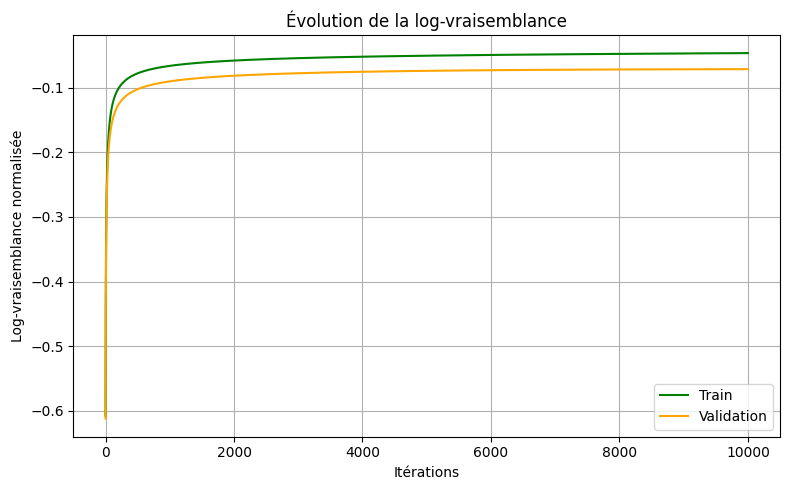

In [50]:
plt.figure(figsize=(8,5))
plt.plot(np.array(history_train)/len(y_train), label='Train', color='green')
plt.plot(np.array(history_val)/len(y_val), label='Validation', color='orange')
plt.xlabel("Itérations")
plt.ylabel("Log-vraisemblance normalisée")
plt.title("Évolution de la log-vraisemblance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

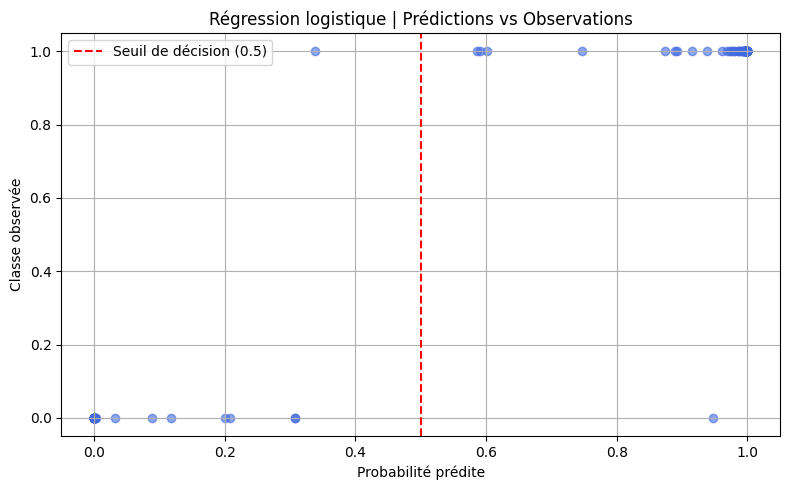

In [51]:
p_pred = sigmoid(X_val @ w_hat)  # Probabilités prédites

y_pred_class = (p_pred >= 0.5).astype(int)
plt.figure(figsize=(8,5))
plt.scatter(p_pred, y_val, alpha=0.6, color='royalblue')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=1.5, label='Seuil de décision (0.5)')
plt.xlabel("Probabilité prédite")
plt.ylabel("Classe observée")
plt.title("Régression logistique | Prédictions vs Observations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# === MÉTRIQUES D'ÉVALUATION | IMPLÉMENTATION MANUELLE ===
def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def compute_precision(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    return TP / (TP + FP + 1e-12)

def compute_recall(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return TP / (TP + FN + 1e-12)

def compute_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-12)

def compute_confusion_matrix(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[TN, FP], [FN, TP]])

# === VISUALISATIONS ===
def plot_log_likelihood(history_train, history_val, y_train, y_val):
    plt.figure(figsize=(8, 5))
    plt.plot(np.array(history_train) / len(y_train), label="Train", color="green")
    plt.plot(np.array(history_val) / len(y_val), label="Validation", color="orange")
    plt.xlabel("Itérations")
    plt.ylabel("Log-vraisemblance normalisée")
    plt.title("Évolution de la log-vraisemblance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_observations(p_pred, y_val):
    plt.figure(figsize=(8, 5))
    plt.scatter(p_pred, y_val, alpha=0.6, color='royalblue')
    plt.axvline(x=0.5, color='red', linestyle='--', linewidth=1.5, label='Seuil de décision (0.5)')
    plt.xlabel("Probabilité prédite")
    plt.ylabel("Classe observée")
    plt.title("Régression Logistique | Prédictions vs Observations")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(conf_mat):
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Classe 0", "Classe 1"],
                yticklabels=["Classe 0", "Classe 1"])
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.title("Matrice de confusion")
    plt.tight_layout()
    plt.show()

def plot_roc_curve(fpr, tpr, auc):
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Faux positifs (FPR)")
    plt.ylabel("Vrais positifs (TPR)")
    plt.title("Courbe ROC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === PCA MANUELLE ===
def manual_pca(X, n_components=2):
    X_centered = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    sorted_idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_idx]
    eigvecs = eigvecs[:, sorted_idx]
    components = eigvecs[:, :n_components]
    X_proj = X_centered @ components
    return X_proj, components

def plot_decision_boundary_pca(X, y, w, title="Frontière de décision (PCA manuelle)"):
    X_proj, components = manual_pca(X, n_components=2)
    x_min, x_max = X_proj[:, 0].min() - 1, X_proj[:, 0].max() + 1
    y_min, y_max = X_proj[:, 1].min() - 1, X_proj[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    X_grid_original = grid @ components.T + np.mean(X, axis=0)
    X_grid_augmented = np.column_stack((np.ones(X_grid_original.shape[0]), X_grid_original))

    def sigmoid(z): return 1 / (1 + np.exp(-z))
    probs = sigmoid(X_grid_augmented @ w).reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=["blue", "orange"])
    plt.contour(xx, yy, probs, levels=[0.5], colors='k', linewidths=1)
    plt.scatter(X_proj[y == 0, 0], X_proj[y == 0, 1], c='blue', label="Classe 0", alpha=0.6)
    plt.scatter(X_proj[y == 1, 0], X_proj[y == 1, 1], c='orange', label="Classe 1", alpha=0.6)
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Coefficients estimés :
Intercept : 0.1159
mean radius : -0.6371
mean texture : -0.4722
mean perimeter : -0.5736
mean area : -0.7119
mean smoothness : -0.4782
mean compactness : 0.7346
mean concavity : -0.7749
mean concave points : -1.0520
mean symmetry : 0.2526
mean fractal dimension : 0.4211
radius error : -1.5648
texture error : -0.0687
perimeter error : -1.0656
area error : -1.1429
smoothness error : -0.2516
compactness error : 0.9291
concavity error : -0.0327
concave points error : -0.4268
symmetry error : 0.3495
fractal dimension error : 0.9970
worst radius : -1.2277
worst texture : -1.2949
worst perimeter : -1.0594
worst area : -1.1812
worst smoothness : -1.0218
worst compactness : 0.1065
worst concavity : -1.0446
worst concave points : -0.9288
worst symmetry : -1.2456
worst fractal dimension : -0.5442


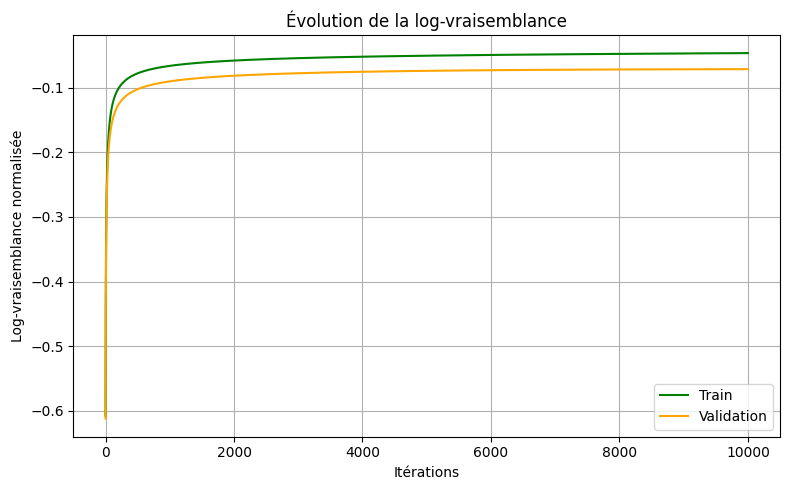

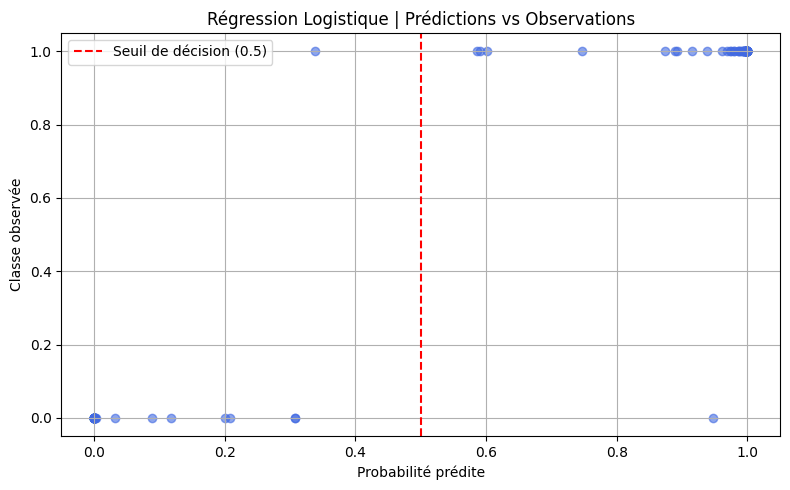


Métriques d'évaluation :
Accuracy  : 0.982
Précision : 0.986
Rappel    : 0.986
F1-score  : 0.986
AUC       : 0.997


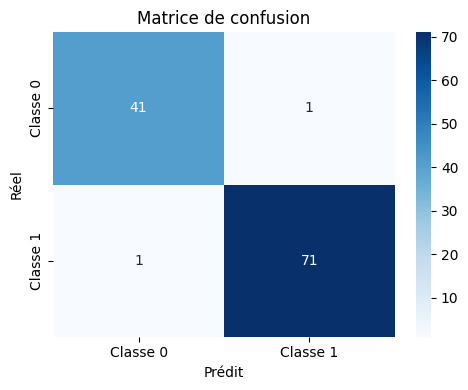

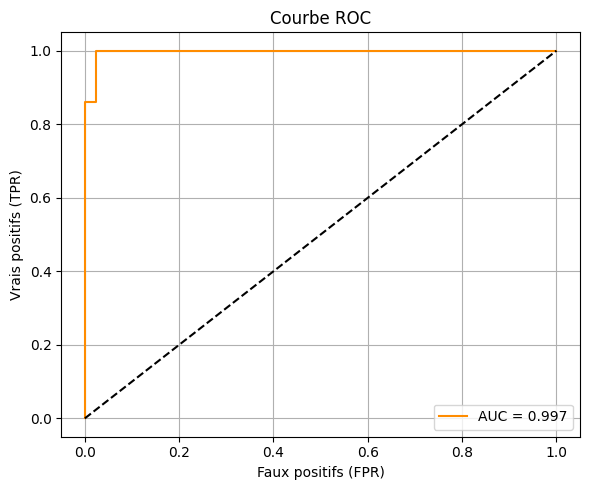

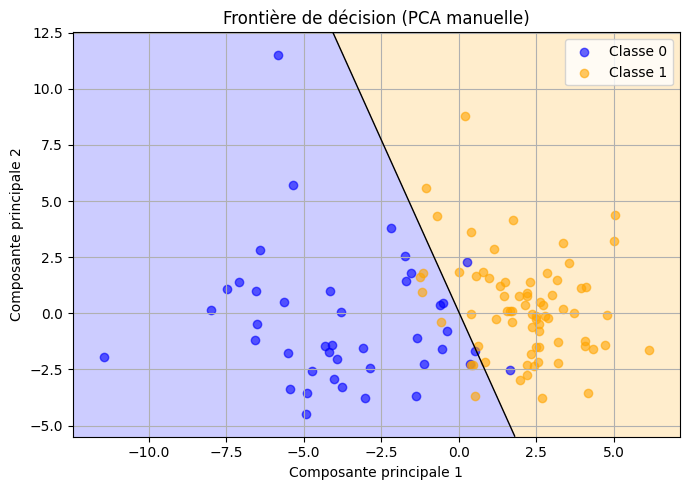

In [53]:
def main():
    # === 1. Chargement et préparation des données ===
    data = load_breast_cancer()
    X_raw, y = data.data, data.target
    feature_names = data.feature_names

    X_train_raw, X_val_raw, y_train, y_val = train_test_split(
        X_raw, y, test_size=0.2, random_state=8302
    )

    # === 2. Standardisation ===
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train_raw)
    X_val_std = scaler.transform(X_val_raw)

    # === 3. Ajout de l'intercept ===
    X_train = np.column_stack((np.ones(X_train_std.shape[0]), X_train_std))
    X_val = np.column_stack((np.ones(X_val_std.shape[0]), X_val_std))

    # === 4. Entraînement ===
    beta_hat, history_train, history_val = logistic_regression(
        X_train, y_train, X_val=X_val, y_val=y_val
    )

    # === 5. Prédictions ===
    p_pred = sigmoid(X_val @ beta_hat)
    y_pred_class = (p_pred >= 0.5).astype(int)

    # === 6. Affichage des coefficients estimés ===
    print("\nCoefficients estimés :")
    for name, coef in zip(['Intercept'] + list(feature_names), beta_hat):
        print(f"{name} : {coef:.4f}")

    # === 7. Visualisation apprentissage et performance ===
    plot_log_likelihood(history_train, history_val, y_train, y_val)
    plot_predictions_vs_observations(p_pred, y_val)

    # === 8. Évaluation manuelle ===
    accuracy = compute_accuracy(y_val, y_pred_class)
    precision = compute_precision(y_val, y_pred_class)
    recall = compute_recall(y_val, y_pred_class)
    f1 = compute_f1(precision, recall)
    conf_mat = compute_confusion_matrix(y_val, y_pred_class)
    fpr, tpr, _ = roc_curve(y_val, p_pred)
    auc = roc_auc_score(y_val, p_pred)

    print("\nMétriques d'évaluation :")
    print(f"Accuracy  : {accuracy:.3f}")
    print(f"Précision : {precision:.3f}")
    print(f"Rappel    : {recall:.3f}")
    print(f"F1-score  : {f1:.3f}")
    print(f"AUC       : {auc:.3f}")

    # === 9. Visualisations finales ===
    plot_confusion_matrix(conf_mat)
    plot_roc_curve(fpr, tpr, auc)
    plot_decision_boundary_pca(X_val[:, 1:], y_val, beta_hat)


# === Exécution du pipeline ===
if __name__ == "__main__":
    main()
